# Ferrofluid - Part II

## Table of Contents
1. [Applying an external magnetic field](#Applying-an-external-magnetic-field)
2. [Magnetization curve](#Magnetization-curve)

**Remark**: The equilibration and sampling times used in this tutorial would be not sufficient for scientific  purposes, but they are long enough to get at least a qualitative insight of the behaviour of ferrofluids. They have been shortened so we achieve reasonable computation times for the purpose of a tutorial.

## Applying an external magnetic field

In this part we want to investigate the influence of an homogeneous external magnetic field exposed to a ferrofluid system.

We import all neccessary packages

In [1]:
import espressomd

from espressomd.magnetostatics import DipolarP3M
from espressomd.magnetostatic_extensions import DLC

import numpy as np

and set up the simulation parameters where we introduce a new dimensionless parameter 

\begin{equation}
    \alpha = \frac{\mu B}{k_BT} = \frac{\mu \mu_0 H}{k_BT}
\end{equation}

which is called **Langevin parameter**. We intentionally choose a relatively high volume fraction $\phi$ and dipolar interaction parameter $\lambda$ to clearly see the influence of the dipole-dipole interaction

In [2]:
# Lennard-Jones parameters
lj_sigma = 1.
lj_epsilon = 1.
lj_cut = 2**(1./6.) * lj_sigma

# Particles
N = 700

# Area fraction of the mono-layer 
phi = 0.06

# Dipolar interaction parameter lambda = mu_0 m^2 /(4 pi sigma^3 kT)
dip_lambda = 4.

# Temperature
kT = 1.0

# Friction coefficient
gamma = 1.0

# Time step
dt = 0.01

# Langevin parameter alpha = mu_0 m H / kT
alpha = 10.

# vaccum permeability
mu_0 = 1.

Now we set up the system, where we, as we did in **part I**, only commit the orientation of the dipole moment to the particles and take the magnitude into account in the prefactor of Dipolar P3M (for more details see **part I**)

In [3]:
# System setup
box_size = (N * np.pi * (lj_sigma/2.)**2. /phi)**0.5

print("Box size",box_size)
# Note that the dipolar P3M and dipolar layer correction need a cubic
# simulation box for technical reasons.
system=espressomd.System(box_l=(box_size,box_size,box_size)) 
system.time_step=dt
system.thermostat.set_langevin(kT=kT,gamma=gamma)
system.set_random_state_PRNG()

# Lennard-Jones interaction
system.non_bonded_inter[0,0].lennard_jones.set_params(epsilon=lj_epsilon,sigma=lj_sigma,cutoff=lj_cut, shift="auto")

# Random dipole moments
dip_phi=np.random.random((N,1)) *2. * np.pi
dip_cos_theta = 2*np.random.random((N,1)) -1
dip_sin_theta = np.sin(np.arccos(dip_cos_theta))
dip = np.hstack((
   dip_sin_theta *np.sin(dip_phi),
   dip_sin_theta *np.cos(dip_phi),
   dip_cos_theta))

# Random positions in the monolayer
pos = box_size* np.hstack((np.random.random((N,2)), np.zeros((N,1))))

# Add particles
system.part.add(pos=pos,rotation=N*[(1,1,1)],dip=dip,fix=N*[(0,0,1)])

# Remove overlap between particles by means of the steepest descent method
system.integrator.set_steepest_descent(
    f_max=0,gamma=0.1,max_displacement=0.05)

while system.analysis.energy()["total"] > 5*kT*N:
    system.integrator.run(20)

# Switch to velocity Verlet integrator
system.integrator.set_vv()

# tune verlet list skin
system.cell_system.tune_skin(min_skin=0.4, max_skin=2., tol=0.2, int_steps=100)

# Setup dipolar P3M and dipolar layer correction
dp3m = DipolarP3M(accuracy=5E-4,prefactor=dip_lambda*lj_sigma**3*kT)
dlc = DLC(maxPWerror=1E-4, gap_size=box_size-lj_sigma)
system.actors.add(dp3m)
system.actors.add(dlc)

# tune verlet list skin again
system.cell_system.tune_skin(min_skin=0.4, max_skin=2., tol=0.2, int_steps=100)

('Box size', 95.72344839677595)
Dipolar P3M tune parameters: Accuracy goal = 5.00000e-04 prefactor = 4.00000e+00
System: box_l = 9.57234e+01 # charged part = 700 Sum[q_i^2] = 7.00000e+02
Dmesh cao Dr_cut_iL   Dalpha_L     Derr         Drs_err    Dks_err    time [ms]
8    3   7.25245e-02 2.57631e+01 4.99236e-04 3.536e-04 3.525e-04 1       
8    2   7.91176e-02 2.22500e+01 4.98928e-04 3.536e-04 3.520e-04 1       
8    4   6.96988e-02 2.74635e+01 4.97910e-04 3.536e-04 3.506e-04 1       
8    1   9.13620e-02 1.69679e+01 4.98425e-04 3.536e-04 3.513e-04 1       
10   2   7.91176e-02 2.22500e+01 5.92199e-04 3.536e-04 4.751e-04 accuracy not achieved
10   3   7.91176e-02 2.22500e+01 5.36848e-04 3.536e-04 4.040e-04 accuracy not achieved
10   4   7.91176e-02 2.22500e+01 5.10933e-04 3.536e-04 3.689e-04 accuracy not achieved
10   5   7.91176e-02 2.22500e+01 4.98506e-04 3.536e-04 3.514e-04 3       
10   6   7.84995e-02 2.25558e+01 4.97788e-04 3.536e-04 3.504e-04 5       
10   7   7.84995e-02 2.25558

1.2999999999999998

We now apply the external magnetic field which is

\begin{equation}
    B = \frac{\alpha~k_BT}{\mu}
\end{equation}

As only the current orientation of the dipole moments, i.e. the unit vector of the dipole moments, is saved in the particle list but not their strength we have to commit $B\cdot \mu$ as the external magnetic field to **ESPResSo**.
We applying the field in x-direction using the class <tt>constraints</tt> of **ESPResSo**

In [4]:
# magnetic field times dipole moment
H_dipm = (alpha*kT)
H_field = [H_dipm,0,0]
print("Set magnetic field constraint...")
H_constraint = espressomd.constraints.HomogeneousMagneticField(H=H_field)
system.constraints.add(H_constraint)

Set magnetic field constraint...


and equilibrate the system for a while

In [5]:
# Equilibrate
print("Equilibration...")
for i in range(10):
  system.integrator.run(1000)
  print("Dipolar energy: %.2f" % system.analysis.energy()["dipolar"])
  print("progress: {:6.2f} %".format((float(i)+1)/10 * 100))
print("Equilibration done")

Equilibration...
Dipolar energy: -9502.18
progress:   3.33 %
Dipolar energy: -10177.94
progress:   6.67 %
Dipolar energy: -10361.14
progress:  10.00 %
Dipolar energy: -10545.17
progress:  13.33 %
Dipolar energy: -10810.05
progress:  16.67 %
Dipolar energy: -10661.31
progress:  20.00 %
Dipolar energy: -10699.38
progress:  23.33 %
Dipolar energy: -10760.10
progress:  26.67 %
Dipolar energy: -10989.97
progress:  30.00 %
Dipolar energy: -10881.94
progress:  33.33 %
Equilibration done


Now we can visualize the current state and see that the particles mostly create chains oriented in the direction of the external magnetic field also some monomers should be present

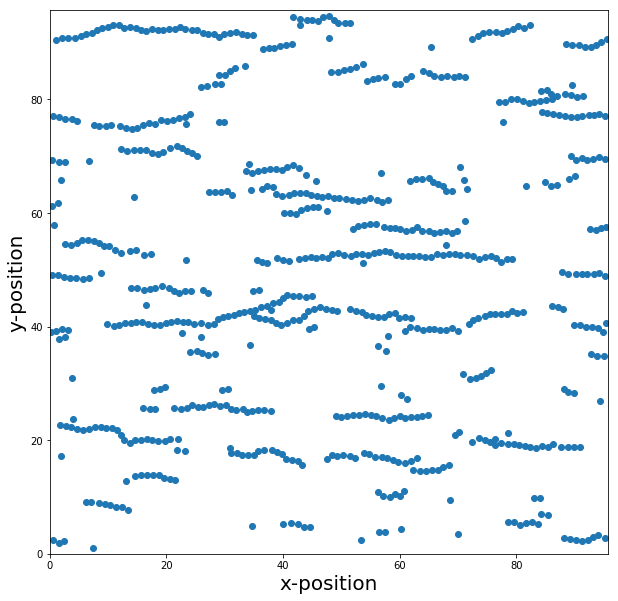

In [7]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.xlim(0, box_size)
plt.ylim(0, box_size)
plt.xlabel('x-position', fontsize=20)
plt.ylabel('y-position', fontsize=20)
plt.plot(system.part[:].pos_folded[:,0], system.part[:].pos_folded[:,1], 'o')
plt.show()

## Video of the development of the system

You may want to get an insight of how the system develops in time. Thus we now create a function which will save a video and embed it in an html string to create a video of the systems development 

In [8]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from tempfile import NamedTemporaryFile

VIDEO_TAG = """<video controls>
 <source src="data:video/x-m4v;base64,{0}" type="video/mp4">
 Your browser does not support the video tag.
</video>"""

def anim_to_html(anim):
    if not hasattr(anim, '_encoded_video'):
        with NamedTemporaryFile(suffix='.mp4') as f:
            anim.save(f.name, fps=20, extra_args=['-vcodec', 'libx264'])
            video = open(f.name, "rb").read()
        anim._encoded_video = video.encode("base64")
        plt.close(anim._fig)
    return VIDEO_TAG.format(anim._encoded_video)

animation.Animation._repr_html_ = anim_to_html

def init():
    # Set x and y range
    ax.set_ylim(0, box_size)
    ax.set_xlim(0, box_size)
    xdata, ydata = [], []
    part.set_data(xdata, ydata)
    return part,

def run(i):
    system.integrator.run(50)

    # Save current system state as a plot
    xdata, ydata = system.part[:].pos_folded[:,0], system.part[:].pos_folded[:,1]
    ax.figure.canvas.draw()
    part.set_data(xdata, ydata)
    print("progress: {} %".format((float(i)+1)/100 * 100))
    return part,

We now can start the sampling over the <tt>animation</tt> class of <tt>matplotlib</tt>

In [9]:
fig, ax = plt.subplots(figsize=(10,10))
part, = ax.plot([],[], 'o')

animation.FuncAnimation(fig, run, frames=100, blit=True, interval=0, repeat=False, init_func=init)

progress: 1.0 %
progress: 2.0 %
progress: 3.0 %
progress: 4.0 %
progress: 5.0 %
progress: 6.0 %
progress: 7.0 %
progress: 8.0 %
progress: 9.0 %
progress: 10.0 %
progress: 11.0 %
progress: 12.0 %
progress: 13.0 %
progress: 14.0 %
progress: 15.0 %
progress: 16.0 %
progress: 17.0 %
progress: 18.0 %
progress: 19.0 %
progress: 20.0 %
progress: 21.0 %
progress: 22.0 %
progress: 23.0 %
progress: 24.0 %
progress: 25.0 %
progress: 26.0 %
progress: 27.0 %
progress: 28.0 %
progress: 29.0 %
progress: 30.0 %
progress: 31.0 %
progress: 32.0 %
progress: 33.0 %
progress: 34.0 %
progress: 35.0 %
progress: 36.0 %
progress: 37.0 %
progress: 38.0 %
progress: 39.0 %
progress: 40.0 %
progress: 41.0 %
progress: 42.0 %
progress: 43.0 %
progress: 44.0 %
progress: 45.0 %
progress: 46.0 %
progress: 47.0 %
progress: 48.0 %
progress: 49.0 %
progress: 50.0 %
progress: 51.0 %
progress: 52.0 %
progress: 53.0 %
progress: 54.0 %
progress: 55.0 %
progress: 56.0 %
progress: 57.0 %
progress: 58.0 %
progress: 59.0 %
progre

In the visualization video we can see that the single chains break and connect to each other during time. Also some monomers are present which break from and connect to chains.

## Magnetization curve

An important observable of a ferrofluid system is the magnetization $M$ of the system in direction of an external magnetic field $H$

\begin{equation}
    M = \frac{\sum_i \mu_i^H}{V}
\end{equation}

where the index $H$ means the component of $\mu_i$ in direction of the external magnetic field $H$ and the sum runs over all particles.

The magnetization plotted over the external field $H$ is called magnetization curve. For particles with non-interacting dipole moments there is an analytical solution

\begin{equation}
    M = M_{sat}\cdot L(\alpha)
\end{equation}

with $L(\alpha)$ the Langevin function

\begin{equation}
    L(\alpha) = \coth(\alpha)-\frac{1}{\alpha}
\end{equation}

and $\alpha$ the Langevin parameter

\begin{equation}
    \alpha=\frac{\mu_0\mu}{k_BT}H = \frac{\mu}{k_BT}B
\end{equation}

$M_{sat}$ is the so called saturation magnetization which is the magnetization of a system where all dipole moments are aligned to each other. Thus it is the maxima of the magnetization. In our case all dipole moments are equal, thus

\begin{equation}
    M_{sat} = \frac{N\cdot\mu}{V}
\end{equation}


For better compairability we now introduce a dimensionless magnetitzation

\begin{equation}
    M^* = \frac{M}{M_{sat}} = \frac{\sum_i \mu_i^H}{N\cdot \mu}
\end{equation}

Thus the analytical solution for non-interacting dipole moments $M^*$ is simply the Langevin function.

For interacting dipole moments there are only approximations for the magnetization curve available. 

Here we want to use the approximation of Ref. [1] for a quasi two dimenstional system, which reads with adjusted coefficients (Ref. [1] used a different dipole-dipole interaction prefactor $\gamma = 1$)

\begin{equation}
    M_{||}^{q2D} = M_{sat} L(\alpha) \left( 1 + \mu_0\frac{1}{8} M_{sat} \frac{d L(\alpha)}{dB} \right)
\end{equation}

and

\begin{equation}
    M_{\perp}^{q2D} = M_{sat} L(\alpha) \left( 1 - \mu_0\frac{1}{4} M_{sat} \frac{d L(\alpha)}{dB} \right)
\end{equation}



for the magnetization with an external magnetic field parallel and perpendicular to the monolayer plane, respectively. Here the dipole-dipole interaction is approximated as a small perturbation and

\begin{equation}
    \frac{d L(\alpha)}{dB} = \left( \frac{1}{\alpha^2} - \frac{1}{\sinh^2(\alpha)} \right) \cdot \frac{\mu}{k_BT}
\end{equation}

By comparing the magnetization curve parallel $M_{||}^{q2D}$ and perpendicular $M_{\perp}^{q2D}$ to the monolayer plane we can see that the magnetization is increased in the case of an external field parallel to the monolayer plane and decreased in the case of an external field perpendicular to the monolayer plane. The latter can be explaned by the fact that an orientation of all single dipole moments perpendicular to the monolayer plane results in a configuration with a repulsive dipole-dipole interaction as the particles have no freedome of movement in the direction perpendicular to the monolayer plane. This counteracts the magnetization perpendicular to the monolayer plane.


We now want to use **ESPResSo** to get an estimation of how the magnetization curve is affected by the dipole-dipole interaction parallel and perpendicular to the monolayer plane and compare the results with the Langevin curve and the magnetization curves of Ref. [1].

For the sampling of the magnetization curve we set up a new system, where we decrease the dipolar interaction parameter $\lambda$ drastically. We do this as we want to compare our results with the approximation of Ref. [1] which is only valid for small dipole-dipole interaction between the particles (decreasing the volume fraction $\phi$ would also be an appropriate choice). As for smaller dipolar interaction parameters it is possible to increase the time step we do this to get more uncorrelated measurements.

In [7]:
# Dipolar interaction parameter lambda = mu_0 m^2 /(4 pi sigma^3 kT)
dip_lambda = 1.

# increase time step
dt = 0.02

# dipole moment
dipm = np.sqrt(dip_lambda*4*np.pi*lj_sigma**3.*kT / mu_0)

In [11]:
# remove all particles
system.part[:].remove()


# Random dipole moments
dip_phi=np.random.random((N,1)) *2. * np.pi
dip_cos_theta = 2*np.random.random((N,1)) -1
dip_sin_theta = np.sin(np.arccos(dip_cos_theta))
dip = np.hstack((
   dip_sin_theta *np.sin(dip_phi),
   dip_sin_theta *np.cos(dip_phi),
   dip_cos_theta))

# Random positions in the monolayer
pos = box_size* np.hstack((np.random.random((N,2)), np.zeros((N,1))))

# Add particles
system.part.add(pos=pos,rotation=N*[(1,1,1)],dip=dip,fix=N*[(0,0,1)])

# Remove overlap between particles by means of the steepest descent method
system.integrator.set_steepest_descent(f_max=0,gamma=0.1,max_displacement=0.05)

while system.analysis.energy()["total"] > 5*kT*N:
    system.integrator.run(20)

# Switch to velocity Verlet integrator
system.integrator.set_vv()

# tune verlet list skin
system.cell_system.tune_skin(min_skin=0.4, max_skin=2., tol=0.2, int_steps=100)

# Setup dipolar P3M and dipolar layer correction
system.actors.remove(dp3m)
system.actors.remove(dlc)

dp3m = DipolarP3M(accuracy=5E-4,prefactor=dip_lambda*lj_sigma**3*kT)
dlc = DLC(maxPWerror=1E-4, gap_size=box_size-lj_sigma)

system.actors.add(dp3m)
system.actors.add(dlc)

# tune verlet list skin again
system.cell_system.tune_skin(min_skin=0.4, max_skin=2., tol=0.2, int_steps=100)

b'Dipolar P3M tune parameters: Accuracy goal = 5.00000e-04 prefactor = 8.00000e-02\nSystem: box_l = 5.11663e+01 # charged part = 1000 Sum[q_i^2] = 1.00000e+03\nDmesh cao Dr_cut_iL   Dalpha_L     Derr         Drs_err    Dks_err    time [ms]\n8    3   2.23603e-01 8.07143e+00 4.95409e-04 3.536e-04 3.470e-04 10      \n8    2   2.36981e-01 7.29601e+00 4.92882e-04 3.535e-04 3.434e-04 10      \n8    4   2.17869e-01 8.43104e+00 4.93503e-04 3.535e-04 3.443e-04 11      \n8    1   2.72337e-01 5.57916e+00 4.96696e-04 3.536e-04 3.489e-04 14      \n10   3   2.09628e-01 8.98090e+00 4.94911e-04 3.535e-04 3.463e-04 9       \n10   2   2.23603e-01 8.07143e+00 4.96956e-04 3.536e-04 3.492e-04 10      \n10   4   2.02640e-01 9.48105e+00 4.94597e-04 3.535e-04 3.459e-04 10      \n10   1   2.23603e-01 8.07143e+00 1.03811e-03 3.536e-04 9.760e-04 accuracy not achieved\n12   3   1.97345e-01 9.88325e+00 4.92836e-04 3.535e-04 3.434e-04 9       \n12   2   2.09628e-01 8.98090e+00 5.23567e-04 3.535e-04 3.862e-04 accura

0.45

To increase the perfomance we use the build-in function <tt>MagneticDipoleMoment</tt> to calculate the dipole  moment of the whole system. In our case this is only the orientation as we never commited the strength of the dipole moments to our particles. 

In [12]:
from espressomd.observables import MagneticDipoleMoment
dipm_tot = MagneticDipoleMoment(ids=system.part[:].id)

We use the dimensionless Langevin parameter $\alpha$ as the parameter for the external magnetic field. As the interesting part of the magnetization curve is the one for small external magnetic field strengths - for large external magnetic fields the magnetization goes into saturation in all cases - we increase the spacing between the Langevin parameters $\alpha$ up to higher values and write them into a list

In [13]:
#alphas = [0, 1/4., 1/2., 3./4., 1., 5./4., 3./2.]
alphas = [0, 0.25, 0.5, 1, 2, 3, 4, 8]

For both the magnetization perpendicular and parallel to the monolayer plane we use the same system for every value of the Langevin parameter $\alpha$. Thus we use that the system is already more or less equilibrated from the previous run so we save some equilibration time. For scientific purposes one would use a new system for every value for the Langevin parameter to ensure that the systems are independent and no correlation effects are measured. Also one would perform more than just one simulation for each value of $\alpha$ to increase the precision of the results.

Now we sample the magnetization for increasing $\alpha$'s or increasing magnetic field in direction perpendicular to the monolayer plane

In [14]:
# sampling with magnetic field perpendicular to monolayer plane (in z-direction)

# remove all constraints
system.constraints.clear()

# list of magnetization in field direction
magnetization_perp = []

# number of loops for sampling
loops = 500

for alpha in alphas:
    print("Sample for alpha = {}".format(alpha))
    H_dipm = (alpha*kT)
    H_field = [0,0,H_dipm]
    print("Set magnetic field constraint...")
    H_constraint = espressomd.constraints.HomogeneousMagneticField(H=H_field)
    system.constraints.add(H_constraint)
    print("done")
    
    # Equilibration
    print("Equilibration...")
    for i in range(10):
        system.integrator.run(1000)
        print("Dipolar energy: %.2f" % system.analysis.energy()["dipolar"])
        print("progress: {:6.2f} %".format((float(i)+1)/10 * 100))
    print("Equlilibration done \n")
    
    # Sampling
    print("Sampling...")
    magn_temp = 0
    for i in range(loops):
        system.integrator.run(20)
        magn_temp += dipm_tot.calculate()[2]
        print("progress: {:6.2f} %".format((float(i)+1)/loops * 100))
    
    # save average magnetization
    magnetization_perp.append(magn_temp / loops)
    print("Sampling for alpha = {} done \n".format(alpha))
    print("magnetizations = {}".format(magnetization_perp))
    print("total progress: {:6.2f} %\n".format((float(alphas.index(alpha))+1)/len(alphas) * 100))
    
    # remove constraint
    system.constraints.clear()
print("Magnetization curve sampling done")

Sample for alpha = 0
Set magnetic field constraint...
done
Equilibration...
Dipolar energy: -1.22
progress:   3.33 %
Dipolar energy: 0.88
progress:   6.67 %
Dipolar energy: -2.58
progress:  10.00 %
Dipolar energy: -2.56
progress:  13.33 %
Dipolar energy: -3.86
progress:  16.67 %
Dipolar energy: -1.24
progress:  20.00 %
Dipolar energy: -1.76
progress:  23.33 %
Dipolar energy: -0.84
progress:  26.67 %
Dipolar energy: -4.10
progress:  30.00 %
Dipolar energy: -0.92
progress:  33.33 %
Dipolar energy: -2.97
progress:  36.67 %
Dipolar energy: -1.32
progress:  40.00 %
Dipolar energy: -1.92
progress:  43.33 %
Dipolar energy: -3.41
progress:  46.67 %
Dipolar energy: -0.91
progress:  50.00 %
Dipolar energy: -3.62
progress:  53.33 %
Dipolar energy: -1.69
progress:  56.67 %
Dipolar energy: -0.00
progress:  60.00 %
Dipolar energy: -1.29
progress:  63.33 %
Dipolar energy: -2.41
progress:  66.67 %
Dipolar energy: -1.39
progress:  70.00 %
Dipolar energy: -0.96
progress:  73.33 %
Dipolar energy: -1.82
p

progress:   3.00 %
progress:   4.00 %
progress:   5.00 %
progress:   6.00 %
progress:   7.00 %
progress:   8.00 %
progress:   9.00 %
progress:  10.00 %
progress:  11.00 %
progress:  12.00 %
progress:  13.00 %
progress:  14.00 %
progress:  15.00 %
progress:  16.00 %
progress:  17.00 %
progress:  18.00 %
progress:  19.00 %
progress:  20.00 %
progress:  21.00 %
progress:  22.00 %
progress:  23.00 %
progress:  24.00 %
progress:  25.00 %
progress:  26.00 %
progress:  27.00 %
progress:  28.00 %
progress:  29.00 %
progress:  30.00 %
progress:  31.00 %
progress:  32.00 %
progress:  33.00 %
progress:  34.00 %
progress:  35.00 %
progress:  36.00 %
progress:  37.00 %
progress:  38.00 %
progress:  39.00 %
progress:  40.00 %
progress:  41.00 %
progress:  42.00 %
progress:  43.00 %
progress:  44.00 %
progress:  45.00 %
progress:  46.00 %
progress:  47.00 %
progress:  48.00 %
progress:  49.00 %
progress:  50.00 %
progress:  51.00 %
progress:  52.00 %
progress:  53.00 %
progress:  54.00 %
progress:  5

progress:  69.00 %
progress:  70.00 %
progress:  71.00 %
progress:  72.00 %
progress:  73.00 %
progress:  74.00 %
progress:  75.00 %
progress:  76.00 %
progress:  77.00 %
progress:  78.00 %
progress:  79.00 %
progress:  80.00 %
progress:  81.00 %
progress:  82.00 %
progress:  83.00 %
progress:  84.00 %
progress:  85.00 %
progress:  86.00 %
progress:  87.00 %
progress:  88.00 %
progress:  89.00 %
progress:  90.00 %
progress:  91.00 %
progress:  92.00 %
progress:  93.00 %
progress:  94.00 %
progress:  95.00 %
progress:  96.00 %
progress:  97.00 %
progress:  98.00 %
progress:  99.00 %
progress: 100.00 %
Sampling for alpha = 4 done 

magnetizations = [6.041190786912352, 293.6774810653525, 516.4915998193595, 658.3393907305958, 741.0333942528623]
total progress:  50.00 %

Sample for alpha = 5
Set magnetic field constraint...
done
Equilibration...
Dipolar energy: -3894.15
progress:   3.33 %
Dipolar energy: -3910.20
progress:   6.67 %
Dipolar energy: -3918.87
progress:  10.00 %
Dipolar energy:

Dipolar energy: -5866.92
progress:  26.67 %
Dipolar energy: -5910.68
progress:  30.00 %
Dipolar energy: -5927.51
progress:  33.33 %
Dipolar energy: -5854.62
progress:  36.67 %
Dipolar energy: -5901.96
progress:  40.00 %
Dipolar energy: -5876.78
progress:  43.33 %
Dipolar energy: -5932.88
progress:  46.67 %
Dipolar energy: -5918.05
progress:  50.00 %
Dipolar energy: -5862.42
progress:  53.33 %
Dipolar energy: -5900.59
progress:  56.67 %
Dipolar energy: -5926.60
progress:  60.00 %
Dipolar energy: -5922.46
progress:  63.33 %
Dipolar energy: -5829.21
progress:  66.67 %
Dipolar energy: -5911.88
progress:  70.00 %
Dipolar energy: -5924.12
progress:  73.33 %
Dipolar energy: -5919.59
progress:  76.67 %
Dipolar energy: -5866.07
progress:  80.00 %
Dipolar energy: -5899.31
progress:  83.33 %
Dipolar energy: -5891.34
progress:  86.67 %
Dipolar energy: -5928.21
progress:  90.00 %
Dipolar energy: -5915.71
progress:  93.33 %
Dipolar energy: -5898.09
progress:  96.67 %
Dipolar energy: -5852.61
progres

progress:   2.00 %
progress:   3.00 %
progress:   4.00 %
progress:   5.00 %
progress:   6.00 %
progress:   7.00 %
progress:   8.00 %
progress:   9.00 %
progress:  10.00 %
progress:  11.00 %
progress:  12.00 %
progress:  13.00 %
progress:  14.00 %
progress:  15.00 %
progress:  16.00 %
progress:  17.00 %
progress:  18.00 %
progress:  19.00 %
progress:  20.00 %
progress:  21.00 %
progress:  22.00 %
progress:  23.00 %
progress:  24.00 %
progress:  25.00 %
progress:  26.00 %
progress:  27.00 %
progress:  28.00 %
progress:  29.00 %
progress:  30.00 %
progress:  31.00 %
progress:  32.00 %
progress:  33.00 %
progress:  34.00 %
progress:  35.00 %
progress:  36.00 %
progress:  37.00 %
progress:  38.00 %
progress:  39.00 %
progress:  40.00 %
progress:  41.00 %
progress:  42.00 %
progress:  43.00 %
progress:  44.00 %
progress:  45.00 %
progress:  46.00 %
progress:  47.00 %
progress:  48.00 %
progress:  49.00 %
progress:  50.00 %
progress:  51.00 %
progress:  52.00 %
progress:  53.00 %
progress:  5

and now we sample the magnetization for increasing $\alpha$'s or increasing magnetic field in direction parallel to the monolayer plane

In [15]:
# sampling with magnetic field parallel to monolayer plane (in x-direction)

# remove all constraints
system.constraints.clear()

# list of magnetization in field direction
magnetization_para = []

# number of loops for sampling
loops = 500

for alpha in alphas:
    print("Sample for alpha = {}".format(alpha))
    H_dipm = (alpha*kT)
    H_field = [H_dipm,0,0]
    print("Set magnetic field constraint...")
    H_constraint = espressomd.constraints.HomogeneousMagneticField(H=H_field)
    system.constraints.add(H_constraint)
    print("done")
    
    # Equilibration
    print("Equilibration...")
    for i in range(10):
        system.integrator.run(1000)
        print("Dipolar energy: %.2f" % system.analysis.energy()["dipolar"])
        print("progress: {:6.2f} %".format((float(i)+1)/10 * 100))
    print("Equlilibration done \n")
    
    # Sampling
    print("Sampling...")
    magn_temp = 0
    for i in range(loops):
        system.integrator.run(20)
        magn_temp += dipm_tot.calculate()[0]
        print("progress: {:6.2f} %".format((float(i)+1)/loops * 100))
    
    # save average magnetization
    magnetization_para.append(magn_temp / loops)
    print("Sampling for alpha = {} done \n".format(alpha))
    print("magnetizations = {}".format(magnetization_para))
    print("total progress: {:6.2f} %\n".format((float(alphas.index(alpha))+1)/len(alphas) * 100))
    
    # remove constraint
    system.constraints.clear()
print("Magnetization curve sampling done")

Sample for alpha = 0
Set magnetic field constraint...
done
Equilibration...
Dipolar energy: 0.84
progress:   3.33 %
Dipolar energy: -0.83
progress:   6.67 %
Dipolar energy: -2.19
progress:  10.00 %
Dipolar energy: 0.05
progress:  13.33 %
Dipolar energy: 0.54
progress:  16.67 %
Dipolar energy: -1.49
progress:  20.00 %
Dipolar energy: -3.73
progress:  23.33 %
Dipolar energy: -1.39
progress:  26.67 %
Dipolar energy: -1.65
progress:  30.00 %
Dipolar energy: -1.28
progress:  33.33 %
Dipolar energy: -0.27
progress:  36.67 %
Dipolar energy: -3.72
progress:  40.00 %
Dipolar energy: 0.45
progress:  43.33 %
Dipolar energy: -1.92
progress:  46.67 %
Dipolar energy: -1.11
progress:  50.00 %
Dipolar energy: -3.48
progress:  53.33 %
Dipolar energy: -2.17
progress:  56.67 %
Dipolar energy: -4.01
progress:  60.00 %
Dipolar energy: -0.27
progress:  63.33 %
Dipolar energy: -2.98
progress:  66.67 %
Dipolar energy: -0.29
progress:  70.00 %
Dipolar energy: -2.69
progress:  73.33 %
Dipolar energy: -1.21
prog

progress:   2.00 %
progress:   3.00 %
progress:   4.00 %
progress:   5.00 %
progress:   6.00 %
progress:   7.00 %
progress:   8.00 %
progress:   9.00 %
progress:  10.00 %
progress:  11.00 %
progress:  12.00 %
progress:  13.00 %
progress:  14.00 %
progress:  15.00 %
progress:  16.00 %
progress:  17.00 %
progress:  18.00 %
progress:  19.00 %
progress:  20.00 %
progress:  21.00 %
progress:  22.00 %
progress:  23.00 %
progress:  24.00 %
progress:  25.00 %
progress:  26.00 %
progress:  27.00 %
progress:  28.00 %
progress:  29.00 %
progress:  30.00 %
progress:  31.00 %
progress:  32.00 %
progress:  33.00 %
progress:  34.00 %
progress:  35.00 %
progress:  36.00 %
progress:  37.00 %
progress:  38.00 %
progress:  39.00 %
progress:  40.00 %
progress:  41.00 %
progress:  42.00 %
progress:  43.00 %
progress:  44.00 %
progress:  45.00 %
progress:  46.00 %
progress:  47.00 %
progress:  48.00 %
progress:  49.00 %
progress:  50.00 %
progress:  51.00 %
progress:  52.00 %
progress:  53.00 %
progress:  5

progress:  68.00 %
progress:  69.00 %
progress:  70.00 %
progress:  71.00 %
progress:  72.00 %
progress:  73.00 %
progress:  74.00 %
progress:  75.00 %
progress:  76.00 %
progress:  77.00 %
progress:  78.00 %
progress:  79.00 %
progress:  80.00 %
progress:  81.00 %
progress:  82.00 %
progress:  83.00 %
progress:  84.00 %
progress:  85.00 %
progress:  86.00 %
progress:  87.00 %
progress:  88.00 %
progress:  89.00 %
progress:  90.00 %
progress:  91.00 %
progress:  92.00 %
progress:  93.00 %
progress:  94.00 %
progress:  95.00 %
progress:  96.00 %
progress:  97.00 %
progress:  98.00 %
progress:  99.00 %
progress: 100.00 %
Sampling for alpha = 4 done 

magnetizations = [-0.7927911693497894, 321.9605507644867, 545.450366787702, 680.0400772779973, 754.7687604880895]
total progress:  50.00 %

Sample for alpha = 5
Set magnetic field constraint...
done
Equilibration...
Dipolar energy: -4053.94
progress:   3.33 %
Dipolar energy: -4084.59
progress:   6.67 %
Dipolar energy: -4050.49
progress:  10.

Dipolar energy: -6045.72
progress:  23.33 %
Dipolar energy: -6031.12
progress:  26.67 %
Dipolar energy: -6051.57
progress:  30.00 %
Dipolar energy: -6090.56
progress:  33.33 %
Dipolar energy: -5984.35
progress:  36.67 %
Dipolar energy: -6063.30
progress:  40.00 %
Dipolar energy: -6065.28
progress:  43.33 %
Dipolar energy: -6037.00
progress:  46.67 %
Dipolar energy: -6076.62
progress:  50.00 %
Dipolar energy: -6028.90
progress:  53.33 %
Dipolar energy: -6063.63
progress:  56.67 %
Dipolar energy: -6062.08
progress:  60.00 %
Dipolar energy: -6056.27
progress:  63.33 %
Dipolar energy: -5936.61
progress:  66.67 %
Dipolar energy: -6016.54
progress:  70.00 %
Dipolar energy: -6045.59
progress:  73.33 %
Dipolar energy: -6027.70
progress:  76.67 %
Dipolar energy: -6034.38
progress:  80.00 %
Dipolar energy: -6072.48
progress:  83.33 %
Dipolar energy: -6067.97
progress:  86.67 %
Dipolar energy: -6043.09
progress:  90.00 %
Dipolar energy: -6058.60
progress:  93.33 %
Dipolar energy: -6074.13
progres

progress:   1.00 %
progress:   2.00 %
progress:   3.00 %
progress:   4.00 %
progress:   5.00 %
progress:   6.00 %
progress:   7.00 %
progress:   8.00 %
progress:   9.00 %
progress:  10.00 %
progress:  11.00 %
progress:  12.00 %
progress:  13.00 %
progress:  14.00 %
progress:  15.00 %
progress:  16.00 %
progress:  17.00 %
progress:  18.00 %
progress:  19.00 %
progress:  20.00 %
progress:  21.00 %
progress:  22.00 %
progress:  23.00 %
progress:  24.00 %
progress:  25.00 %
progress:  26.00 %
progress:  27.00 %
progress:  28.00 %
progress:  29.00 %
progress:  30.00 %
progress:  31.00 %
progress:  32.00 %
progress:  33.00 %
progress:  34.00 %
progress:  35.00 %
progress:  36.00 %
progress:  37.00 %
progress:  38.00 %
progress:  39.00 %
progress:  40.00 %
progress:  41.00 %
progress:  42.00 %
progress:  43.00 %
progress:  44.00 %
progress:  45.00 %
progress:  46.00 %
progress:  47.00 %
progress:  48.00 %
progress:  49.00 %
progress:  50.00 %
progress:  51.00 %
progress:  52.00 %
progress:  5

Now we can compare the resulting magnetization curves with the Langevin curve and the more advanced ones of Ref. [1] by plotting all of them in one figure. Thus first we import matplotlib if not already done

In [21]:
import matplotlib.pyplot as plt

For the approximations of $ M_{||}^{q2D}$ and $ M_{\perp}^{q2D}$ of Ref. [1] we need the dipole moment of a single particle. Thus we calculate it from our dipolar interaction parameter $\lambda$

In [24]:
# dipole moment
dipm = np.sqrt(dip_lambda*4*np.pi*lj_sigma**3.*kT / mu_0)
print('dipole moment = {}'.format(dipm))

dipole moment = 3.54490770181


and the saturation magnetization by using

\begin{equation}
    M_{sat} = \rho \mu = \phi \frac{4}{\pi \sigma^2} \mu
\end{equation}
thus

In [25]:
M_sat = phi * 4./np.pi * 1./(lj_sigma**2.) * dipm

Further we need the derivation of the Langevin function after the external field B thus we define the function

In [26]:
def dL_dB(alpha):
    return (1./(alpha**2.) - 1./((np.sinh(alpha))**2.)) * dipm / (kT)

Now we define the approximated magnetization curves parallel and perpendicular to the monolayer plane

In [27]:
# approximated magnetization curve for a field parallel to the monolayer plane
def magnetization_approx_para(phi, alpha):
    return L(alpha) * ( 1. + mu_0/8. * M_sat * dL_dB(alpha) )

In [28]:
# approximated magnetization curve for a field perpendicular to the monolayer plane
def magnetization_approx_perp(phi, alpha):
    return L(alpha) * ( 1. - mu_0/4. * M_sat * dL_dB(alpha) )

Now we define the Langevin function

In [ ]:
# Langevin function
def L(x):
    return (np.cosh(x)/np.sinh(x)) - 1./x

and plot the three theoretical curves together with our simulation results

In [32]:
# list of the values for alpha (x-axis)
x = np.arange(0.01,9, 0.1, dtype=float).tolist()


L_func = []
L_perp = []
L_para = []
for i in x:
    L_func.append(L(i))
    L_perp.append(magnetization_approx_perp(phi, i))
    L_para.append(magnetization_approx_para(phi, i))
    

# devide all entries in the magnetization list by N to get the dimensionless magnetization
magnetization_perp_star = []
magnetization_para_star = []
for i in range(len(magnetization_para)):
    magnetization_perp_star.append(magnetization_perp[i] / N)
    magnetization_para_star.append(magnetization_para[i] / N)



plt.figure(figsize=(10,10))
plt.xlabel(r'$\alpha$', fontsize=20)
plt.ylabel(r'$M^*$', fontsize=20)
plt.plot(x, L_func, label='Langevin function')
plt.plot(x, L_perp, label='q2D approximation $\perp$')
plt.plot(x, L_para, label='q2D approximation ||')
plt.plot(alphas, magnetization_perp_star, 'o', label='simulation results $\perp$')
plt.plot(alphas, magnetization_para_star, 'o', label='simulation results ||')
plt.legend(fontsize=20)
plt.show()

NameError: name 'magnetization_para' is not defined

We can see that the simulation results are better represented by the curves of Ref. [1] compared to the Langevin function. This was to be expected as the Langevin function is the magnetization curve of the real three dimenstional system without dipole-dipole interaction. We can also see that the magnetization is smaller in the case of an external magnetic field perpendicular to the monolayer plane compared to the parallel case.

Feel free to experiment with different dipolar interaction parameters $\lambda$ up to around 4 and different area fractions $\phi$ up to around 0.4. For higher values the here used simple sampling method is not applicable as the particles form clusters of very high relaxation times exceeding normal simulation times by far. Therefore more advanced methods are necessary to increase the sampling performance.

It should also be noted that perhaps thereby one has to decrease the time step as for higher values of the dipolar interaction parameter and the area fraction the interaction between the particles is stronger.

[1] Tamás Kristóf and István Szalai. “Magnetic properties in monolayers of a model
polydisperse ferrofluid”. In: Phys. Rev. E 72 (4 Oct. 2005), p. 041105. doi: 10.1103/
PhysRevE.72.041105. url: https://link.aps.org/doi/10.1103/PhysRevE.72.
041105.